# importing libraries

In [1]:
import soundfile # to read audio file
import numpy as np
import librosa # to extract speech features
import glob
import os
import pickle # to save model after training        
from sklearn.model_selection import train_test_split # for splitting training and testing
from sklearn.neural_network import MLPClassifier # multi-layer perceptron model
from sklearn.metrics import accuracy_score # to measure how good we are
import matplotlib.pyplot as plt

# defining our labels dictionary

In [3]:
# all emotions on RAVDESS dataset
int2emotion = {
    "01": "neutral",
    "02": "calm",
    "03": "happy",
    "04": "sad",
    "05": "angry",
    "06": "fearful",
    "07": "disgust",
    "08": "surprised"
}

# we allow only these emotions ( feel free to tune this on your need )
AVAILABLE_EMOTIONS = {
    "angry",
    "sad",
    "neutral",
    "happy"
}


In [4]:
sounds = []
for file in glob.glob("data/Actor_*/*.wav"):
    with soundfile.SoundFile(file) as sound_file:
        X = sound_file.read(dtype="float32")
        sounds.append(X)
print(len(sounds), sounds[0].shape)

564 (52853,)


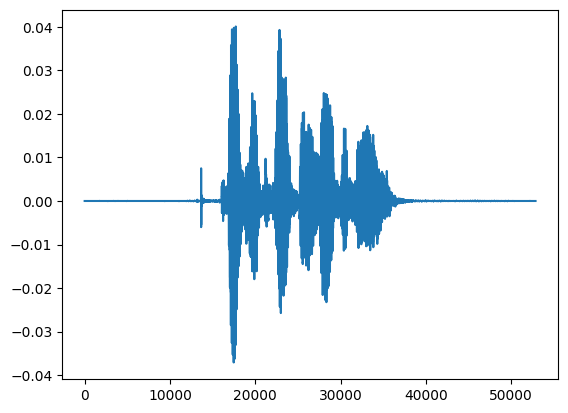

In [5]:
plt.plot(sounds[0])

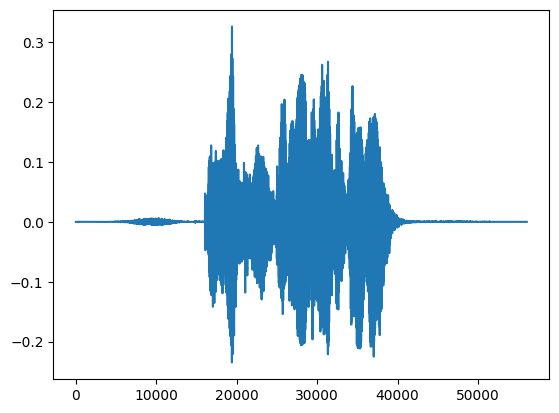

In [6]:
plt.plot(sounds[-1])

In [ ]:
emotions = []
for file in glob.glob("data/Actor_*/*.wav"):
    # get the base name of the audio file
    basename = os.path.basename(file)
    # get the emotion label
    emotion = int2emotion[basename.split("-")[2]]
    # we allow only AVAILABLE_EMOTIONS we set
    if emotion not in AVAILABLE_EMOTIONS:
        continue
    # extract speech features
    emotions.append(emotion)

In [10]:
def load_data(test_size=0.2):
    X, y = [], []
    for file in glob.glob("data/Actor_*/*.wav"):
        # get the base name of the audio file
        basename = os.path.basename(file)
        # get the emotion label
        emotion = int2emotion[basename.split("-")[2]]
        # we allow only AVAILABLE_EMOTIONS we set
        if emotion not in AVAILABLE_EMOTIONS:
            continue
        # extract speech features
        features = extract_feature(file, mfcc=True, chroma=True)
        # add to data
        X.append(features)
        y.append(emotion)
    # split the data to training and testing and return it
    return train_test_split(np.array(X), y, test_size=test_size, random_state=7)

In [8]:
def extract_feature(file_name, **kwargs):
    mfcc = kwargs.get("mfcc")
    chroma = kwargs.get("chroma")
    mel = kwargs.get("mel")
    contrast = kwargs.get("contrast")
    tonnetz = kwargs.get("tonnetz")
    with soundfile.SoundFile(file_name) as sound_file:
        X = sound_file.read(dtype="float32")
        sample_rate = sound_file.samplerate
        if chroma or contrast:
            stft = np.abs(librosa.stft(X))
        result = np.array([])
        if mfcc:
            mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T, axis=0)
            result = np.hstack((result, mfccs))
        if chroma:
            chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
            result = np.hstack((result, chroma))
        if mel:
            mel = np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T,axis=0)
            result = np.hstack((result, mel))
        if contrast:
            contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate).T,axis=0)
            result = np.hstack((result, contrast))
        if tonnetz:
            tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(X), sr=sample_rate).T,axis=0)
            result = np.hstack((result, tonnetz))
    return result

In [11]:
# load RAVDESS dataset, 75% training 25% testing
X_train, X_test, y_train, y_test = load_data(test_size=0.25)

In [14]:
X_train.shape

(189, 52)

In [15]:
len(y_train)

189

In [20]:
# best model, determined by a grid search
model_params = {
    'alpha': 0.01,
    'batch_size': 256,
    'epsilon': 1e-08, 
    'hidden_layer_sizes': (300,), 
    'learning_rate': 'adaptive', 
    'max_iter': 500, 
}

In [17]:
# initialize Multi Layer Perceptron classifier
# with best parameters ( so far )
model = MLPClassifier(**model_params)

In [18]:
# train the model
print("[*] Training the model...")
model.fit(X_train, y_train)

[*] Training the model...


c:\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:621: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(


MLPClassifier(alpha=0.01, batch_size=256, hidden_layer_sizes=(300,),
              learning_rate='adaptive', max_iter=500)

In [19]:
# predict 25% of data to measure how good we are
y_pred = model.predict(X_test)

# calculate the accuracy
accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)

print("Accuracy: {:.2f}%".format(accuracy*100))

Accuracy: 65.08%


In [21]:
# now we save the model
# make result directory if doesn't exist yet
if not os.path.isdir("result"):
    os.mkdir("result")

pickle.dump(model, open("result/mlp_classifier.model", "wb"))

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

In [ ]:


model = RandomForestClassifier(n_estimators=1000, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
precision = precision_score(y_true=y_test, y_pred=y_pred, average='weighted')
recall = recall_score(y_true=y_test, y_pred=y_pred, average='weighted')
f1 = f1_score(y_true=y_test, y_pred=y_pred, average='weighted')
cm = confusion_matrix(y_true=y_test, y_pred=y_pred)

